### Imports

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

### LSTM Model with Hyperparameter Tuning

Trial 100 Complete [00h 00m 27s]
val_loss: 0.005570669658482075

Best val_loss So Far: 0.00394898746162653
Total elapsed time: 03h 05m 31s
Optimal number of units: 164
Optimal dropout rate: 0.1
Optimal learning rate: 0.0009499173325705382
Epoch 1/200
14/14 [==============================] - 2s 42ms/step - loss: 0.0526 - mae: 0.1747 - val_loss: 0.0233 - val_mae: 0.1244
Epoch 2/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0131 - mae: 0.0856 - val_loss: 0.0100 - val_mae: 0.0754
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0098 - mae: 0.0727 - val_loss: 0.0089 - val_mae: 0.0644
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0087 - mae: 0.0671 - val_loss: 0.0081 - val_mae: 0.0632
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0076 - mae: 0.0622 - val_loss: 0.0084 - val_mae: 0.0628
Epoch 6/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0073 - mae: 0.0612 - val_

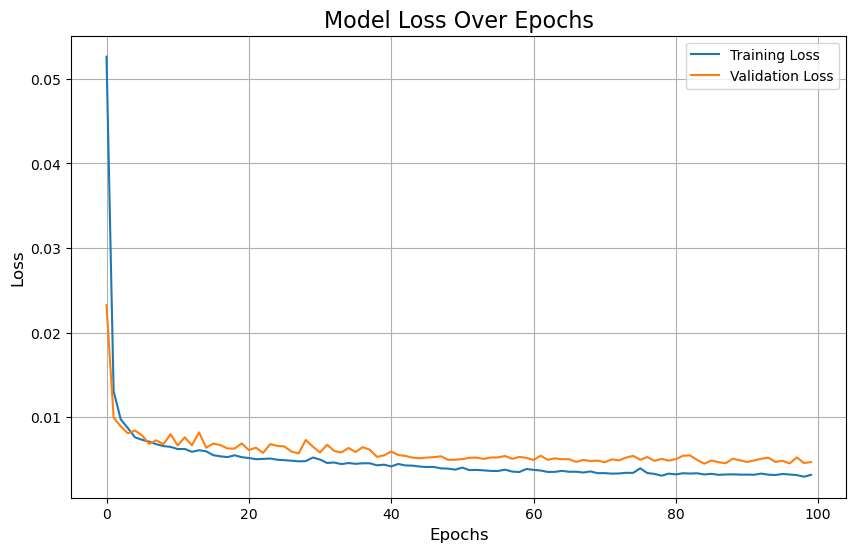

7/7 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0390
Test Loss: 0.004522388800978661
Test MAE: 0.03900410607457161
7/7 [==============================] - 0s 3ms/step


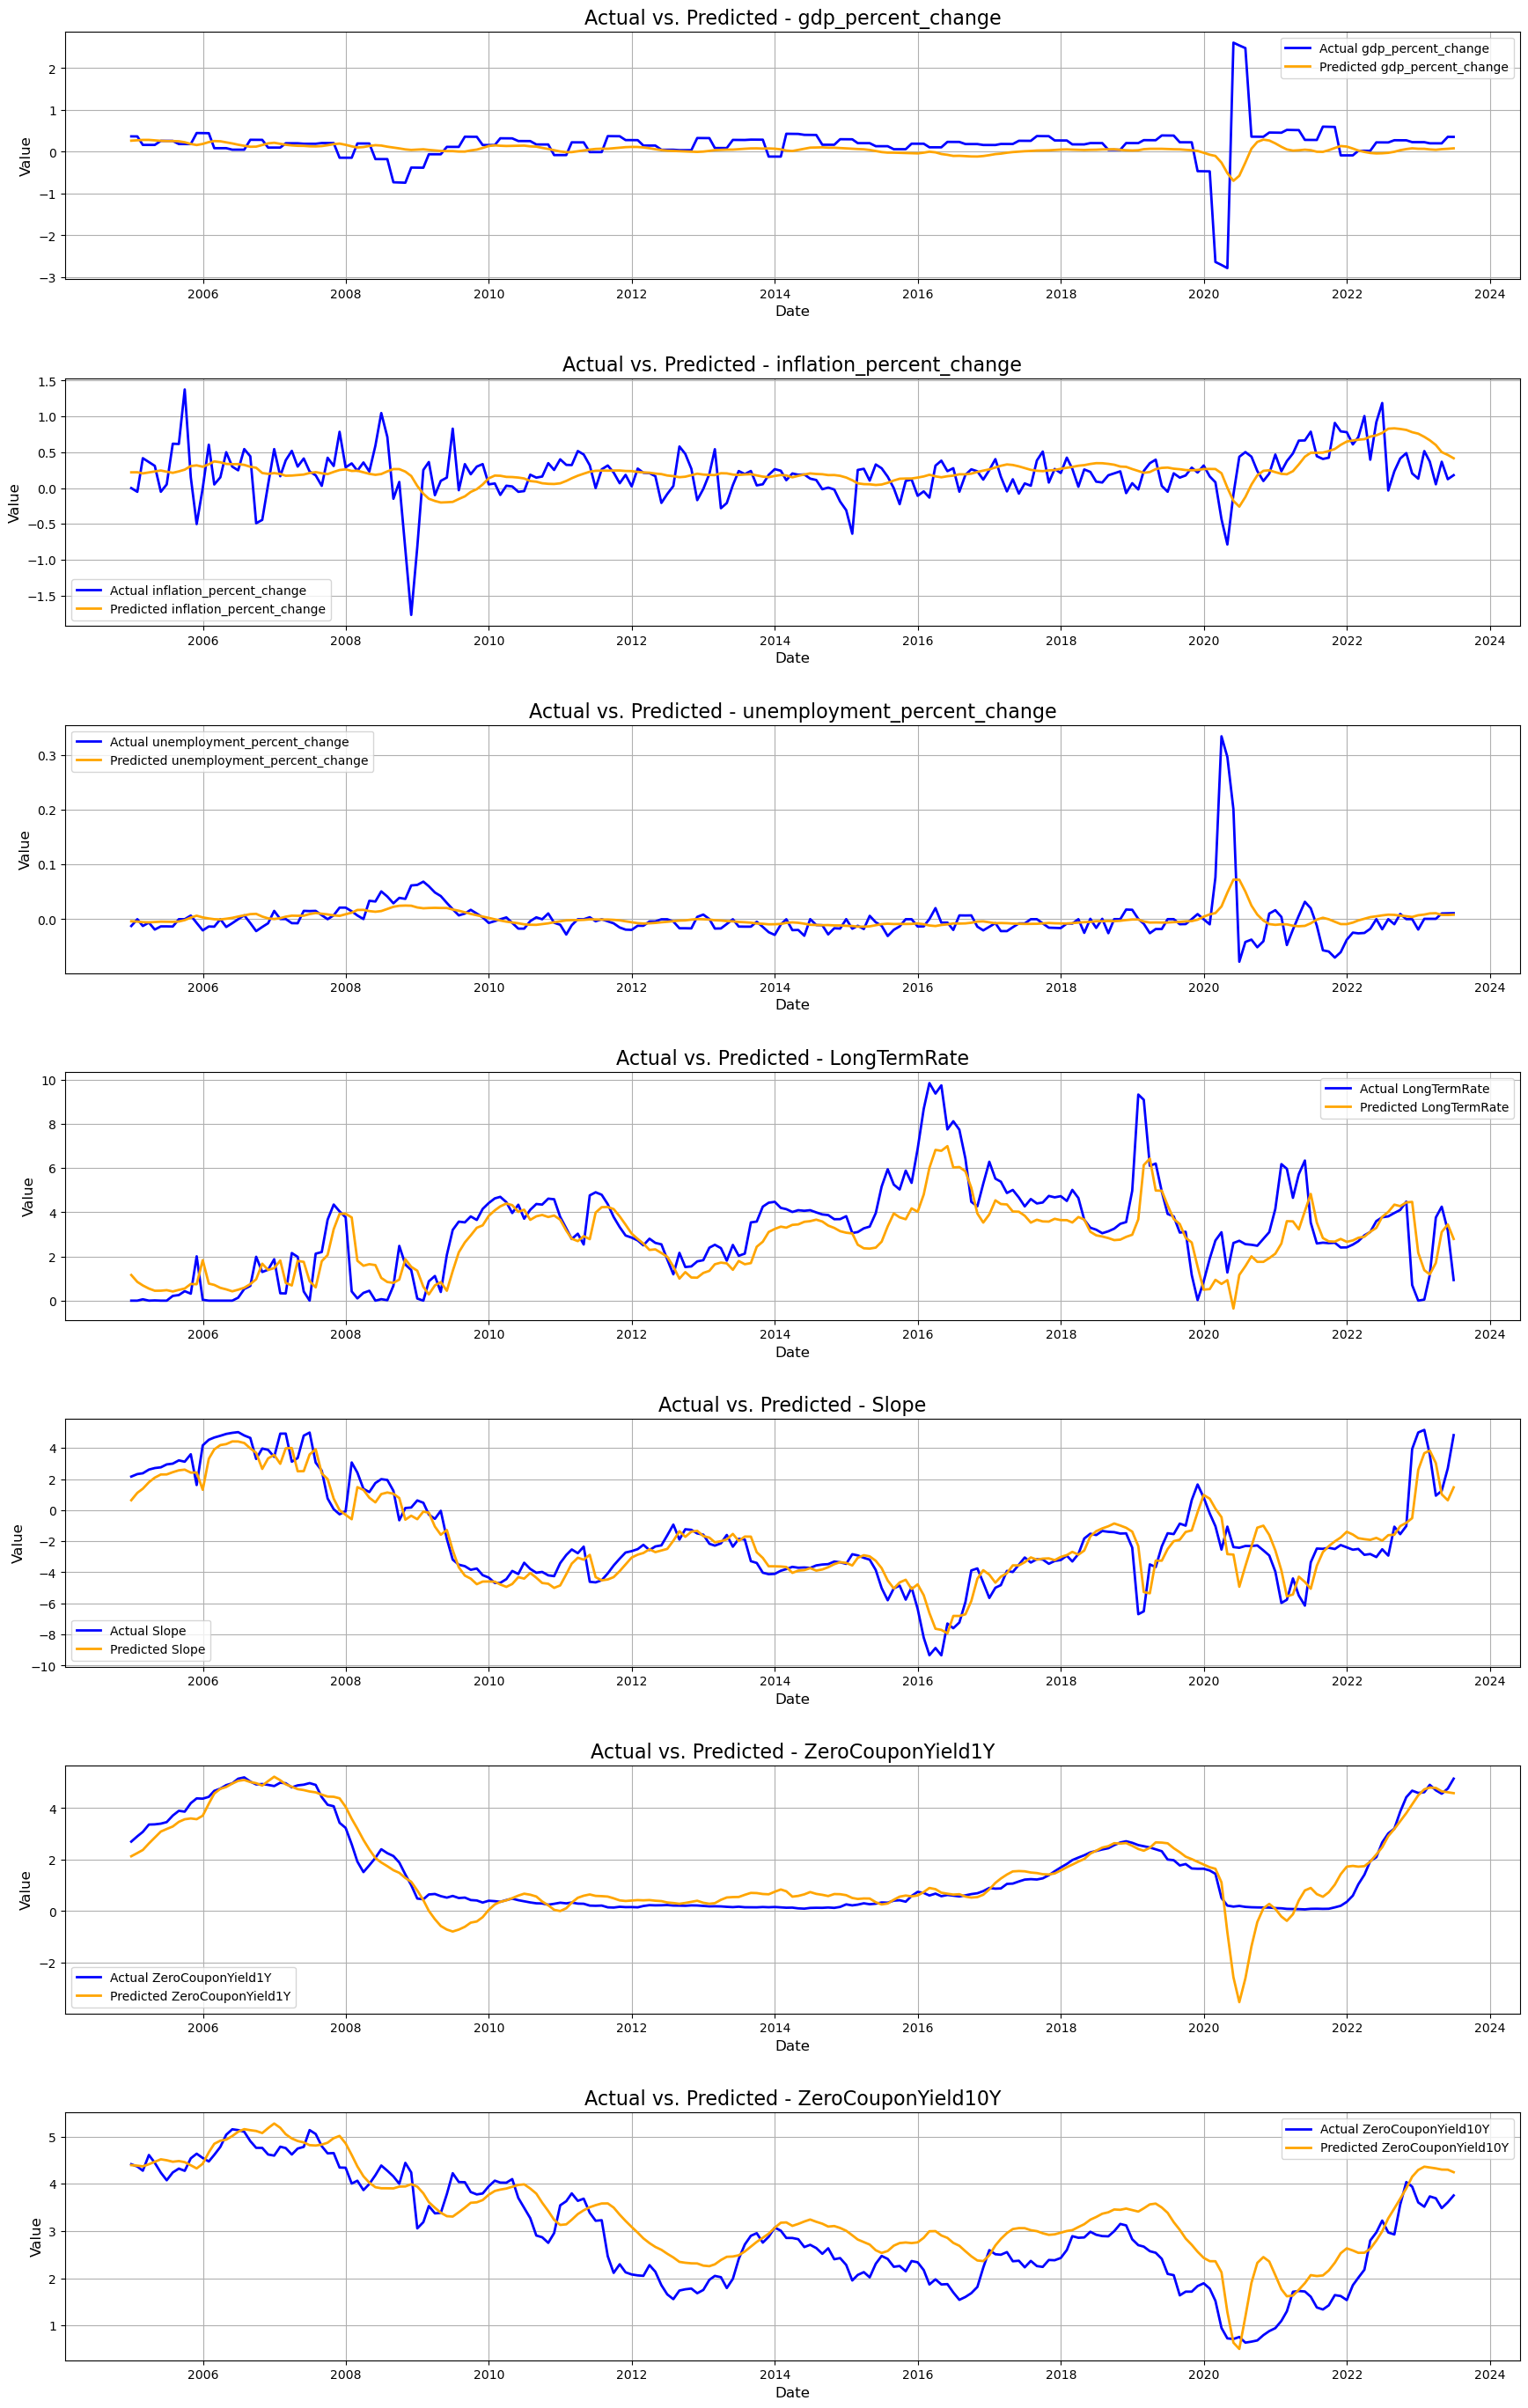

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 164)           112832    
                                                                 
 dropout_2 (Dropout)         (None, 12, 164)           0         
                                                                 
 lstm_3 (LSTM)               (None, 164)               215824    
                                                                 
 dropout_3 (Dropout)         (None, 164)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1155      
                                                                 
Total params: 329,811
Trainable params: 329,811
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Load and preprocess the data
data = pd.read_csv("data/merged_data.csv")
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.sort_index(inplace=True)

# Drop Recession column for better results (will be used in classification model)
data = data.drop(columns=['Recession'], errors='ignore')

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Sliding window
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12  # Use the past 12 months to predict the next month
X, y = create_sequences(scaled_data, look_back)

# Define dividing point between training and testing datasets
split_date = pd.Timestamp('2005-01-01')

# Find the index closest to the split_date
split_index = data.index.get_indexer([split_date], method='nearest')[0]

# Adjust for the look-back period
adjusted_split_index = max(0, split_index - look_back)

# Split the data into training and testing sets based on the adjusted split index
X_train, X_test = X[:adjusted_split_index].astype('float32'), X[adjusted_split_index:].astype('float32')
y_train, y_test = y[:adjusted_split_index], y[adjusted_split_index:]

# Extract corresponding dates for y_test
test_dates = data.index[adjusted_split_index + look_back:]  # Adjust for the look-back

# Ensure the sequential split aligns correctly with the data
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")

# Build the LSTM model
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int('units', min_value=100, max_value=256, step=32),
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(
        LSTM(
            units=hp.Int('units', min_value=100, max_value=256, step=32),
            activation='tanh',
            recurrent_activation='sigmoid',
        )
    )
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(y_train.shape[1], activation='linear'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    return model

# Hyperparameter tuning 
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_prediction_update'
)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=100, 
    validation_data=(X_test, y_test), 
    batch_size=16, verbose=1, )

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

# Train the best model with Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Stop after 15 epochs with no improvement
    restore_best_weights=True  # Restore the weights of the best model
)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train, 
    epochs=200, 
    validation_data=(X_test, y_test), 
    batch_size=32, 
    callbacks=[early_stopping],  
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Save the trained model
best_model.save("best_lstm_model_update.h5")

# Predict and inverse transform the results
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Save predictions to a CSV file
predicted_df = pd.DataFrame(y_test, index=test_dates, columns=data.columns)
predicted_df.to_csv("data/LSTM_predicted_values.csv")

# Plot actual vs predicted values for each feature
num_features = y_test.shape[1]

plt.figure(figsize=(18, num_features * 4))  
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(test_dates, y_test_inverse[:, i], label=f'Actual {data.columns[i]}', color='blue', linewidth=2)
    plt.plot(test_dates, predictions[:, i], label=f'Predicted {data.columns[i]}', color='orange', linewidth=2)
    plt.title(f"Actual vs. Predicted - {data.columns[i]}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid()

plt.tight_layout(pad=3.0)  
plt.show()

best_model.summary()
